In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# Define dataset path
real_bearing_path = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Real paderborn"

# Define transformations
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
dataset_real = ImageFolder(root=real_bearing_path, transform=image_transforms)

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(dataset_real))
test_size = len(dataset_real) - train_size
train_dataset_real, test_dataset_real = random_split(dataset_real, [train_size, test_size])

# Create DataLoaders
batch_size = 8
train_dataloader_real = DataLoader(train_dataset_real, batch_size=batch_size, shuffle=True)
test_dataloader_real = DataLoader(test_dataset_real, batch_size=batch_size, shuffle=False)

# Define Model
class BearingFaultClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(BearingFaultClassifier, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  # Remove FC layer

        # Attention Mechanism
        self.attn_q = nn.Linear(512, 512)
        self.attn_k = nn.Linear(512, 512)
        self.attn_v = nn.Linear(512, 512)
        self.attn = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)

        # Bi-LSTM
        self.lstm = nn.LSTM(input_size=512, hidden_size=512, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(0.5)  # Increase dropout
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet(x)  
        x = x.view(x.shape[0], -1, 512)  # Flatten

        q, k, v = self.attn_q(x), self.attn_k(x), self.attn_v(x)
        x, _ = self.attn(q, k, v)

        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Get last LSTM output

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BearingFaultClassifier(num_classes=3).to(device)

# Define Loss and Optimizer
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Training Loop
num_epochs = 30
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 7

for epoch in range(num_epochs):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for batch_X, batch_y in train_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)

    scheduler.step()  # Adjust learning rate
    train_acc = 100 * correct_train / total_train
    train_loss = total_train_loss / len(train_dataloader_real)

    # Validation Phase
    model.eval()
    total_val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for batch_X, batch_y in test_dataloader_real:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss = total_val_loss / len(test_dataloader_real)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")


Epoch [1/30] - Train Acc: 73.56% | Val Acc: 85.43%
Epoch [2/30] - Train Acc: 84.03% | Val Acc: 89.92%
Epoch [3/30] - Train Acc: 85.55% | Val Acc: 85.10%
Epoch [4/30] - Train Acc: 87.71% | Val Acc: 88.35%
Epoch [5/30] - Train Acc: 90.07% | Val Acc: 91.43%
Epoch [6/30] - Train Acc: 90.95% | Val Acc: 95.07%
Epoch [7/30] - Train Acc: 91.80% | Val Acc: 92.10%
Epoch [8/30] - Train Acc: 92.03% | Val Acc: 95.97%
Epoch [9/30] - Train Acc: 92.88% | Val Acc: 93.50%
Epoch [10/30] - Train Acc: 93.34% | Val Acc: 95.29%
Epoch [11/30] - Train Acc: 93.36% | Val Acc: 97.03%
Epoch [12/30] - Train Acc: 93.61% | Val Acc: 96.02%
Epoch [13/30] - Train Acc: 93.92% | Val Acc: 96.25%
Epoch [14/30] - Train Acc: 93.12% | Val Acc: 94.12%
Epoch [15/30] - Train Acc: 91.40% | Val Acc: 95.69%
Epoch [16/30] - Train Acc: 91.66% | Val Acc: 93.84%
Epoch [17/30] - Train Acc: 90.02% | Val Acc: 91.93%
Epoch [18/30] - Train Acc: 89.77% | Val Acc: 90.08%
Epoch [19/30] - Train Acc: 88.94% | Val Acc: 94.23%
Epoch [20/30] - Train

In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        ce_loss = self.ce_loss(logits, labels)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Replace criterion
criterion = FocalLoss()


In [16]:
# Get class names from the dataset
class_labels_real = dataset_real.classes
print("Class Labels:", class_labels_real)


Class Labels: ['IR Real', 'Normal', 'OR Real']


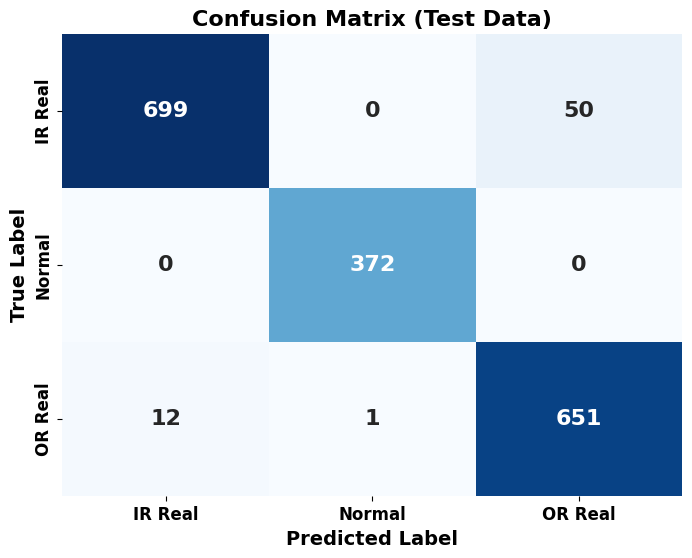


Classification Report:
               precision    recall  f1-score   support

     IR Real       0.98      0.93      0.96       749
      Normal       1.00      1.00      1.00       372
     OR Real       0.93      0.98      0.95       664

    accuracy                           0.96      1785
   macro avg       0.97      0.97      0.97      1785
weighted avg       0.97      0.96      0.96      1785



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ensure model is in evaluation mode
model.eval()

# Get test predictions
test_preds = []
test_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_labels_real)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_real, yticklabels=class_labels_real, 
            cbar=False, annot_kws={"size": 16, "fontweight": "bold"})  # Bigger font for better readability

# Labels and title
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
#plt.title('Confusion Matrix (Test Data)', fontsize=16, fontweight='bold')

# Make axis labels bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save & Show
#plt.savefig("confusion_matrix_test.png", dpi=1000)  # High-resolution save
plt.show()

# Print Classification Report
print("\nClassification Report:\n", report)


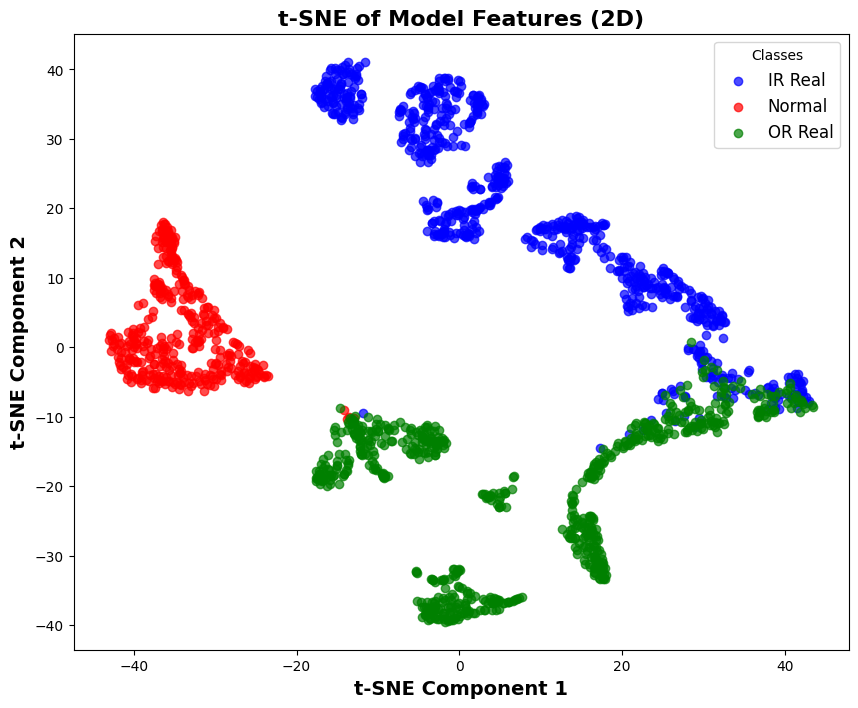

In [16]:
from sklearn.manifold import TSNE
import numpy as np

# Convert features into 2D space using t-SNE
features_list = []
labels_list = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        features = model.resnet(batch_X)  # Extract features before classification
        features_list.append(features.cpu().numpy())
        labels_list.append(batch_y.cpu().numpy())

# Convert to numpy arrays
features_array = np.concatenate(features_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
features_tsne = tsne.fit_transform(features_array.reshape(features_array.shape[0], -1))

# Plot t-SNE
plt.figure(figsize=(10, 8))
class_colors = ['blue', 'red', 'green']
for i, class_name in enumerate(class_labels_real):
    plt.scatter(features_tsne[labels_array == i, 0], features_tsne[labels_array == i, 1], 
                label=class_name, alpha=0.7, marker='o', color=class_colors[i])

plt.legend(title="Classes", loc='upper right', fontsize=12)
plt.title('t-SNE of Model Features (2D)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
#plt.savefig("real_bearing_tsne.png", dpi=1000)
plt.show()


In [17]:
from collections import Counter

train_labels = [label for _, label in train_dataset_real]  # Extract all labels
print("Training Sample Distribution:", Counter(train_labels))


Training Sample Distribution: Counter({0: 3077, 2: 2514, 1: 1546})


In [11]:
print(f"Total Samples in t-SNE Plot: {features_array.shape[0]}")
print(f"Expected Test Samples: {len(test_dataset_real)}")


Total Samples in t-SNE Plot: 1785
Expected Test Samples: 1785


In [18]:
import torch.nn.functional as F

class WeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, weights):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weights = torch.tensor(weights).float().to(device)

    def forward(self, inputs, targets):
        return F.cross_entropy(inputs, targets, weight=self.weights)

# Compute class weights (inverse frequency)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_counts = [3077, 1546, 2514]  # IR Real, Normal, OR Real
class_weights = compute_class_weight('balanced', classes=np.unique([0,1,2]), y=[0]*3077 + [1]*1546 + [2]*2514)
print(f"Class Weights: {class_weights}")

# Apply weighted loss
criterion = WeightedCrossEntropyLoss(weights=class_weights)


Class Weights: [0.77315567 1.53880983 0.94630072]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# Define dataset path
real_bearing_path = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Real paderborn"

# Define data transformations with stronger augmentations
# Define transformations (Fix Applied)
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.RandomHorizontalFlip(p=0.5),  # Augment data
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for better training
])


# Load dataset
dataset_real = ImageFolder(root=real_bearing_path, transform=image_transforms)

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(dataset_real))
test_size = len(dataset_real) - train_size
train_dataset_real, test_dataset_real = random_split(dataset_real, [train_size, test_size])

# Create DataLoaders
batch_size = 32  # Increased batch size for stability
train_dataloader_real = DataLoader(train_dataset_real, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader_real = DataLoader(test_dataset_real, batch_size=batch_size, shuffle=False, num_workers=4)

# Define Model
class BearingFaultClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(BearingFaultClassifier, self).__init__()
        self.efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-1])  # Remove FC layer

        # Attention Mechanism (Scaled Dot-Product Attention)
        self.attn_q = nn.Linear(1280, 1280)
        self.attn_k = nn.Linear(1280, 1280)
        self.attn_v = nn.Linear(1280, 1280)
        self.attn = nn.MultiheadAttention(embed_dim=1280, num_heads=8, batch_first=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(1280, 512)
        self.dropout = nn.Dropout(0.6)  # Increased dropout to reduce overfitting
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.efficientnet(x)  # Feature extraction
        x = x.view(x.shape[0], -1, 1280)  # Flatten
        
        # Attention Mechanism
        q, k, v = self.attn_q(x), self.attn_k(x), self.attn_v(x)
        x, _ = self.attn(q, k, v)
        
        # Fully Connected
        x = x[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BearingFaultClassifier(num_classes=3).to(device)

# Define Loss and Optimizer
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum()

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Training Loop
num_epochs = 50
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 10  # Increased patience

for epoch in range(num_epochs):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for batch_X, batch_y in train_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)

    scheduler.step()  # Adjust learning rate
    train_acc = 100 * correct_train / total_train
    train_loss = total_train_loss / len(train_dataloader_real)

    # Validation Phase
    model.eval()
    total_val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for batch_X, batch_y in test_dataloader_real:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss = total_val_loss / len(test_dataloader_real)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "new_best_model.pth")
    
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered!")
        break

Epoch [1/50] - Train Acc: 78.39% | Val Acc: 87.39%
Epoch [2/50] - Train Acc: 90.05% | Val Acc: 92.66%
Epoch [3/50] - Train Acc: 91.90% | Val Acc: 95.35%
Epoch [4/50] - Train Acc: 93.78% | Val Acc: 96.25%
Epoch [5/50] - Train Acc: 94.23% | Val Acc: 96.13%
Epoch [6/50] - Train Acc: 95.60% | Val Acc: 94.62%
Epoch [7/50] - Train Acc: 96.05% | Val Acc: 96.36%
Epoch [8/50] - Train Acc: 96.51% | Val Acc: 97.20%
Epoch [9/50] - Train Acc: 96.40% | Val Acc: 97.59%
Epoch [10/50] - Train Acc: 96.55% | Val Acc: 96.30%
Epoch [11/50] - Train Acc: 95.78% | Val Acc: 97.31%
Epoch [12/50] - Train Acc: 96.40% | Val Acc: 96.08%
Epoch [13/50] - Train Acc: 96.69% | Val Acc: 96.64%
Epoch [14/50] - Train Acc: 95.89% | Val Acc: 96.97%
Epoch [15/50] - Train Acc: 96.81% | Val Acc: 98.82%
Epoch [16/50] - Train Acc: 97.35% | Val Acc: 98.15%
Epoch [17/50] - Train Acc: 97.79% | Val Acc: 98.77%
Epoch [18/50] - Train Acc: 97.93% | Val Acc: 97.25%
Epoch [19/50] - Train Acc: 97.94% | Val Acc: 97.98%
Epoch [20/50] - Train

In [31]:
# Training Loop
num_epochs = 50
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 10  # Increased patience

In [9]:
torch.save(model.state_dict(), "new_best_model.pth")


In [10]:
# Redefine your model and device
model = BearingFaultClassifier(num_classes=3).to(device)

# Load the saved weights
model.load_state_dict(torch.load("new_best_model.pth"))

# Set to evaluation mode
model.eval()


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_18948\2669026508.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("new_best_model.pth

BearingFaultClassifier(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [11]:
start_epoch = 47
num_epochs = 50  # Continue until 50 or more if needed

for epoch in range(start_epoch, num_epochs):
    model.train()
    # Training loop as before...


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

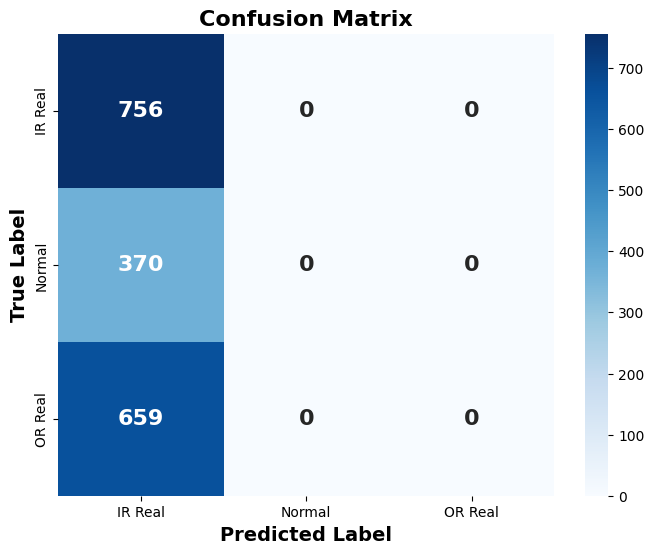

Classification Report:
               precision    recall  f1-score   support

     IR Real       0.42      1.00      0.60       756
      Normal       0.00      0.00      0.00       370
     OR Real       0.00      0.00      0.00       659

    accuracy                           0.42      1785
   macro avg       0.14      0.33      0.20      1785
weighted avg       0.18      0.42      0.25      1785



In [17]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure model is in eval mode
model.eval()

# Get predictions and true labels
test_preds = []
test_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_labels_real)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_real, yticklabels=class_labels_real,
            annot_kws={"size": 16, "fontweight": "bold"})
plt.xlabel("Predicted Label", fontsize=14, fontweight='bold')
plt.ylabel("True Label", fontsize=14, fontweight='bold')
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.show()

# Print Report
print("Classification Report:\n", report)


In [18]:
from sklearn.manifold import TSNE
import numpy as np

# Extract features
features_list = []
labels_list = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X = batch_X.to(device)
        features = model.efficientnet(batch_X)
        features = features.view(features.size(0), -1)
        features_list.append(features.cpu().numpy())
        labels_list.append(batch_y.cpu().numpy())

# Stack and t-SNE
features_array = np.vstack(features_list)
labels_array = np.concatenate(labels_list)

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# Plot t-SNE
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i, label in enumerate(class_labels_real):
    idx = labels_array == i
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1],
                c=colors[i], label=label, marker=markers[i], alpha=0.7)

plt.xlabel("t-SNE Component 1", fontsize=14, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=14, fontweight='bold')
plt.title("t-SNE of Real Bearing Test Data", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: 'BearingFaultClassifier' object has no attribute 'efficientnet'

In [19]:
model = BearingFaultClassifier(num_classes=3).to(device)


In [20]:
model.load_state_dict(torch.load("new_best_model.pth"))


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_18948\1519783286.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("new_best_model.pth

<All keys matched successfully>

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)


In [23]:
start_epoch = 47  # Last saved epoch
num_epochs = 50   # Total epochs

for epoch in range(start_epoch + 1, num_epochs + 1):
    # Same training and validation loop as before
    ...


In [24]:
print("Resuming from saved model...")
model.eval()


Resuming from saved model...


BearingFaultClassifier(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BearingFaultClassifier(num_classes=3).to(device)


In [26]:
model.load_state_dict(torch.load("new_best_model.pth"))
print("✅ Model weights loaded successfully")


✅ Model weights loaded successfully


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_18948\4024305145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("new_best_model.pth

In [27]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)


In [32]:
start_epoch = 47
num_epochs = 50

for epoch in range(start_epoch + 1, num_epochs + 1):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for batch_X, batch_y in train_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)

    scheduler.step()
    train_acc = 100 * correct_train / total_train
    train_loss = total_train_loss / len(train_dataloader_real)

    # Validation
    model.eval()
    total_val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_dataloader_real:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss = total_val_loss / len(test_dataloader_real)

    print(f"Epoch [{epoch}/{num_epochs}] - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "new_best_model.pth")


Epoch [48/50] - Train Acc: 89.59% | Val Acc: 85.55%
Epoch [49/50] - Train Acc: 92.92% | Val Acc: 92.32%
Epoch [50/50] - Train Acc: 94.34% | Val Acc: 92.55%


In [29]:
# Define Loss and Optimizer
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum()

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

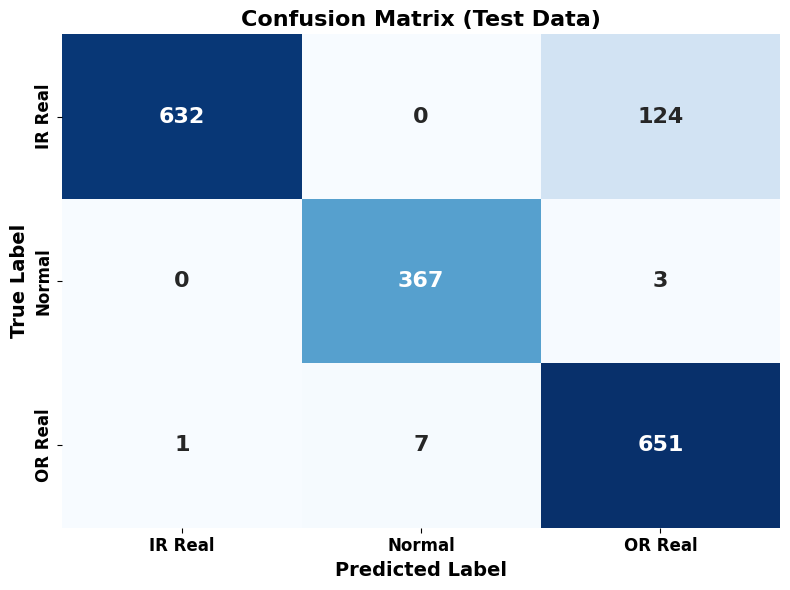


Classification Report:
               precision    recall  f1-score   support

     IR Real       1.00      0.84      0.91       756
      Normal       0.98      0.99      0.99       370
     OR Real       0.84      0.99      0.91       659

    accuracy                           0.92      1785
   macro avg       0.94      0.94      0.93      1785
weighted avg       0.94      0.92      0.92      1785



In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Set model to eval mode
model.eval()

# Get predictions and labels
test_preds = []
test_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_labels_real)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels_real, yticklabels=class_labels_real, 
            cbar=False, annot_kws={"size": 16, "fontweight": "bold"})

plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Confusion Matrix (Test Data)', fontsize=16, fontweight='bold')
plt.tight_layout()
#plt.savefig("confusion_matrix_real_test.png", dpi=1000)
plt.show()

# Print classification report
print("\nClassification Report:\n", report)


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


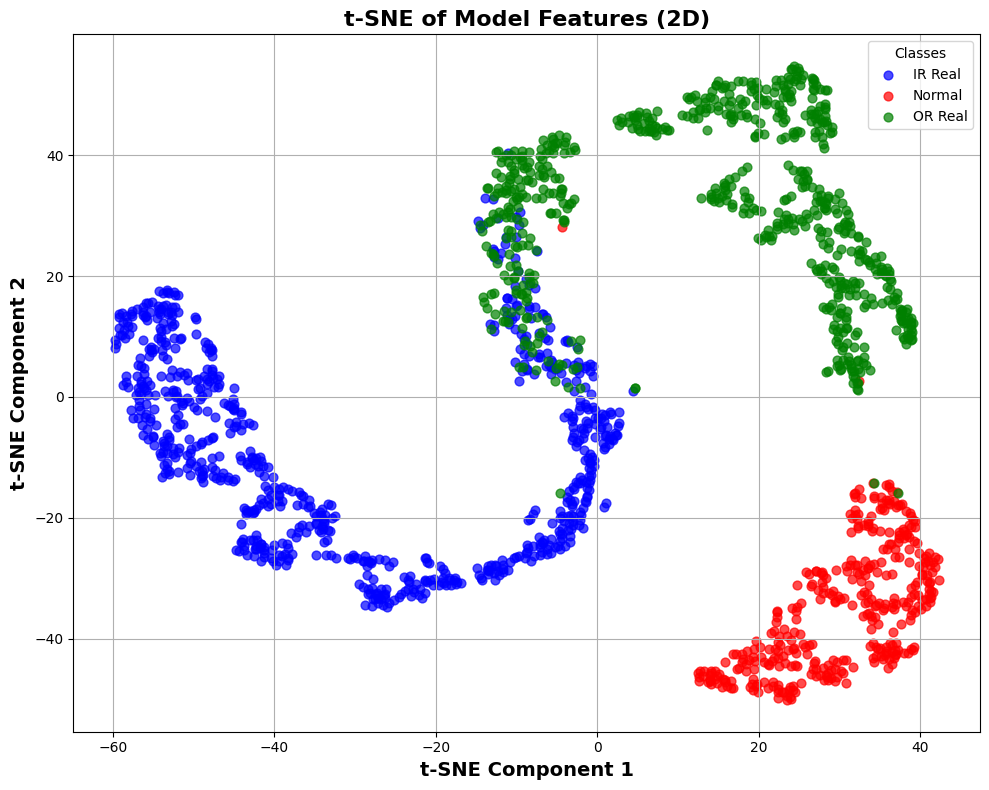

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Set model to eval
model.eval()

# Lists to store features and labels
features_list = []
labels_list = []

with torch.no_grad():
    for batch_X, batch_y in test_dataloader_real:
        batch_X = batch_X.to(device)
        outputs = model.resnet(batch_X)  # Extract features before attention/LSTM
        outputs = outputs.view(outputs.size(0), -1, 512)  # Reshape for attention
        q, k, v = model.attn_q(outputs), model.attn_k(outputs), model.attn_v(outputs)
        attn_out, _ = model.attn(q, k, v)
        lstm_out, _ = model.lstm(attn_out)
        final_features = lstm_out[:, -1, :].cpu().numpy()  # Get final representation

        features_list.append(final_features)
        labels_list.extend(batch_y.cpu().numpy())

# Stack all feature vectors
features_np = np.vstack(features_list)
labels_np = np.array(labels_list)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(features_np)

# Plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
class_labels = ['IR Real', 'Normal', 'OR Real']

for i, label in enumerate(np.unique(labels_np)):
    idx = labels_np == label
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], 
                label=class_labels[i], alpha=0.7, s=40, color=colors[i])

plt.xlabel("t-SNE Component 1", fontsize=14, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=14, fontweight='bold')
plt.title("t-SNE of Model Features (2D)", fontsize=16, fontweight='bold')
plt.legend(title="Classes")
plt.grid(True)
plt.tight_layout()
#plt.savefig("tsne_real_bearing.png", dpi=1000)
plt.show()


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import os

# Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, smoothing=0.1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets, num_classes).float()
        targets_one_hot = targets_one_hot * (1 - self.smoothing) + self.smoothing / num_classes
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        focal_weight = self.alpha * ((1 - probs) ** self.gamma)
        loss = -targets_one_hot * focal_weight * log_probs
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Classifier Model
class BearingFaultClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(BearingFaultClassifier, self).__init__()
        self.efficientnet = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier = nn.Identity()
        self.attn_q = nn.Linear(1280, 1280)
        self.attn_k = nn.Linear(1280, 1280)
        self.attn_v = nn.Linear(1280, 1280)
        self.attn = nn.MultiheadAttention(embed_dim=1280, num_heads=8, batch_first=True)
        self.fc1 = nn.Linear(1280, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.efficientnet(x)
        x = x.view(x.size(0), -1, 1280)
        q, k, v = self.attn_q(x), self.attn_k(x), self.attn_v(x)
        x, _ = self.attn(q, k, v)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
path = r"E:\\Collaboration Work\\With Farooq\\Bearings MDPI\\Real paderborn"
dataset = ImageFolder(root=path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BearingFaultClassifier(num_classes=3).to(device)
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Training loop
best_val_loss = float('inf')
patience = 10
counter = 0
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_efficientnet_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\Muhammad Umar/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:07<00:00, 11.1MB/s]


KeyboardInterrupt: 